# Python Notebook for remote sensing work
Repository made for Artificial Intelligence & Neural Network course with Prof. Ciarfuglia @ Sapienza 

Import necessary items with this:

In [1]:
# Let's import our own modules
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

We should test that the CUDA platform has been successfully recognized and it's being in use with pyTorch

In [2]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())

Using PyTorch version: 2.3.0+cu121  Device: cuda
PyTorch version:  2.3.0+cu121
CUDA version:  12.1
cuDNN version:  8902


# Some parameters, used for hyperparameter tuning later

Here we'll setup some parameters, that will be used for hyperparameter tuning once we have a PoC that actually works

In [3]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
INITIAL_LR = 1e-4
MAX_LR = 1e-2
SIZE = 200
NUM_WORKERS = 8
BATCH_SIZE = 16
EPOCHS = 16
LOAD_BEST = True

# Let's define some paths
DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

# TODO:
 - dataset analysis
 - mean and standard deviation calculatiom

# Data analysis

Before starting, we need to do some preliminary analysis on our dataset.
Inside split_dataset.py we already split our images into 3 different categories.
We'll be using:
 - train.txt as a training dataset
 - val.txt to validate that our model correctly predicts masks
 - test.txt to challenge different models one against the other

We should also calculate mean and std values of our train dataset, and we'll apply them to all of our sets


In [4]:
""" mean, std = utils.get_mean_std(path_to_train_data="data/train/AOI_11_Rotterdam/splits/train.txt")
print("Mean: ", mean)
print("Std: ", std) 
"""

' mean, std = utils.get_mean_std(path_to_train_data="data/train/AOI_11_Rotterdam/splits/train.txt")\nprint("Mean: ", mean)\nprint("Std: ", std) \n'

# Create a dataset class

Now we'll need to create a SN6Dataset derived from data.Dataset that will import the data and return the data and labels, and that implements __len__ and __getitem__ methods
We'll be using RasterIO

We can see the implementation of the dataset in src/dataset.py

In [5]:
train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.Resize(SIZE, SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.Resize(SIZE, SIZE)
])

from dataset import SN6Dataset

train_dataset = SN6Dataset(DATASET_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='val')

# Use DataLoader

We'll now import the dataset into a dataloader, and just to see that everything's working we'll show the first image of the batch

Since we have normalized the images the image won't be shown correctly. That's normal, since now the values are centered in zero




Image shape: torch.Size([16, 3, 200, 200]), Mask shape: torch.Size([16, 1, 200, 200])


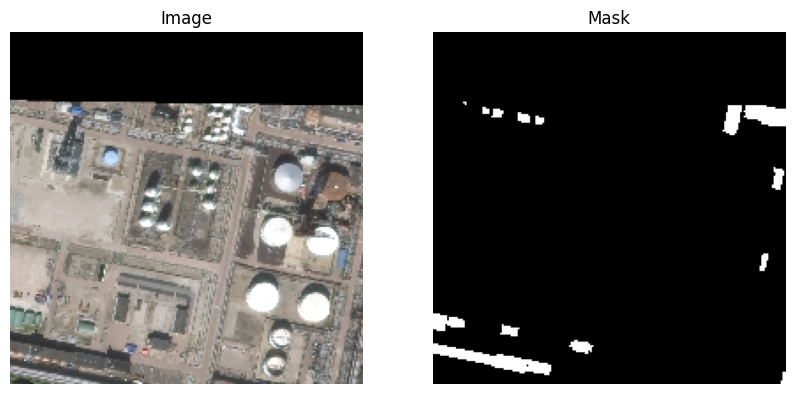

In [6]:
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True, num_workers=NUM_WORKERS)

image, mask = next(iter(train_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

# Define the training model

For our task, we'll be employing the power of UNET, a specific type of Convolutional Neural Network (CNN), which is a popular architecture for image segmentation tasks, being widely used in various domains including medical imaging and remote sensing.

As we proceed with the implementation, please note that you might encounter a warning message related to cudnn. This is a known issue. It's documented and can be further explored HERE. Despite this warning, training can continue normally.

In [7]:
from model import UNET
from train import train

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss() # first we'll use BCEWithLogitsLoss, then we'll try with L1Loss since it's the best metric for the homework
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)

# We won't use a scheduler at first, but we'll add it later
# torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, anneal_strategy='cos')
scheduler = None
scaler = torch.cuda.amp.GradScaler()


let's do the actual training!

In [8]:
best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
    'dice' : []
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + "best.pth")):
        history, last_epoch = utils.load_checkpoint(CHECKPOINT_PATH + "best.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
    else:
        print("Best model not found, starting from scratch")

# Training model
for epoch in range(last_epoch, EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
    # Detect if loss is NaN, and immediately stop with a ValueError 
    if train_loss != train_loss:
        raise ValueError("Loss is NaN, something is VERY wrong, stopping training")
    
    eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path="data/eval")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(eval_loss)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['accuracy'].append(accuracy)
    print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
    # Save model
    checkpoint = {
        "history" : history,
        "epoch" : epoch,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": criterion.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "checkpoint.pth")
    if f1 > best_f1:
        best_f1 = f1
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "best.pth")
        print("Best model saved")

    if epoch - 3 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
        if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2]:
            print("Early stopping")
            break
print("Finished training! Well done :3\nQuitting...")

Restoring best model
loading checkpoint
Epoch 7 of 16


Loss: 0.1429: 100%|██████████| 170/170 [00:45<00:00,  3.77it/s]

Saving predictions to: data/eval


Train loss: 0.1366 Eval loss: 0.6908 Precision: 0.6536 Recall: 0.6501 F1: 0.6518 Accuracy: 0.9529
saving checkpoint
saving checkpoint
Best model saved
Epoch 8 of 16


Loss: 0.1051: 100%|██████████| 170/170 [00:48<00:00,  3.53it/s]

Saving predictions to: data/eval


Train loss: 0.1270 Eval loss: 0.6856 Precision: 0.7448 Recall: 0.6408 F1: 0.6889 Accuracy: 0.9607
saving checkpoint
saving checkpoint
Best model saved
Epoch 9 of 16


Loss: 0.0976: 100%|██████████| 170/170 [00:43<00:00,  3.87it/s]

Saving predictions to: data/eval


Train loss: 0.1182 Eval loss: 0.6885 Precision: 0.7048 Recall: 0.5017 F1: 0.5862 Accuracy: 0.9519
saving checkpoint
Epoch 10 of 16


Loss: 0.1299: 100%|██████████| 170/170 [00:44<00:00,  3.86it/s]

Saving predictions to: data/eval


Train loss: 0.1136 Eval loss: 0.6899 Precision: 0.6616 Recall: 0.7579 F1: 0.7065 Accuracy: 0.9573
saving checkpoint
saving checkpoint
Best model saved
Epoch 11 of 16


Loss: 0.1167: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]

Saving predictions to: data/eval


Train loss: 0.1077 Eval loss: 0.6847 Precision: 0.7697 Recall: 0.6609 F1: 0.7112 Accuracy: 0.9636
saving checkpoint
saving checkpoint
Best model saved
Epoch 12 of 16


Loss: 0.1085: 100%|██████████| 170/170 [00:44<00:00,  3.81it/s]

Saving predictions to: data/eval


Train loss: 0.1016 Eval loss: 0.6867 Precision: 0.7233 Recall: 0.6791 F1: 0.7005 Accuracy: 0.9606
saving checkpoint
Epoch 13 of 16


Loss: 0.1053: 100%|██████████| 170/170 [00:44<00:00,  3.84it/s]

Saving predictions to: data/eval


Train loss: 0.0961 Eval loss: 0.6820 Precision: 0.8201 Recall: 0.6746 F1: 0.7403 Accuracy: 0.9679
saving checkpoint
saving checkpoint
Best model saved
Epoch 14 of 16


Loss: 0.0860: 100%|██████████| 170/170 [00:52<00:00,  3.22it/s]

Saving predictions to: data/eval


Train loss: 0.0954 Eval loss: 0.6852 Precision: 0.7416 Recall: 0.7308 F1: 0.7361 Accuracy: 0.9645
saving checkpoint
Epoch 15 of 16


Loss: 0.0851: 100%|██████████| 170/170 [00:46<00:00,  3.64it/s]

Saving predictions to: data/eval


Train loss: 0.0903 Eval loss: 0.6819 Precision: 0.8301 Recall: 0.6665 F1: 0.7394 Accuracy: 0.9681
saving checkpoint
Epoch 16 of 16


Loss: 0.0664: 100%|██████████| 170/170 [00:44<00:00,  3.86it/s]

Saving predictions to: data/eval


Train loss: 0.0887 Eval loss: 0.6823 Precision: 0.7962 Recall: 0.7131 F1: 0.7524 Accuracy: 0.9682
saving checkpoint
saving checkpoint
Best model saved
Finished training! Well done :3
Quitting...


The high precision and accuracy values observed might initially suggest that our model is performing exceptionally well. However, this could be a misleading indicator due to the nature of our dataset.

In image segmentation tasks such as this, our images likely contain a large number of black pixels representing the background. The model could simply predict most pixels as black, and because such a large proportion of the image is indeed black, it would be correct a high percentage of the time. This results in a high accuracy score, but it doesn't necessarily mean our model is doing a good job at the actual task of interest - identifying and segmenting the non-black regions.

Precision, while a more robust metric, can also be inflated in this scenario. Precision measures the proportion of positive identifications that were actually correct. If the model is conservative and mostly predicts the abundant black pixels, it can also achieve a high precision.

This is why we need to be cautious and not take these high precision and accuracy values at face value. It's crucial to focus more on optimizing the f1-score, which provides a more balanced measure of the model's performance. The f1-score considers both precision and recall (the ability of the model to find all the positive samples), giving us a more holistic view of the model's performance. In a task where the positive class (non-black pixels) is of great interest and vastly outnumbered, the f1-score becomes an especially important metric.

loading checkpoint


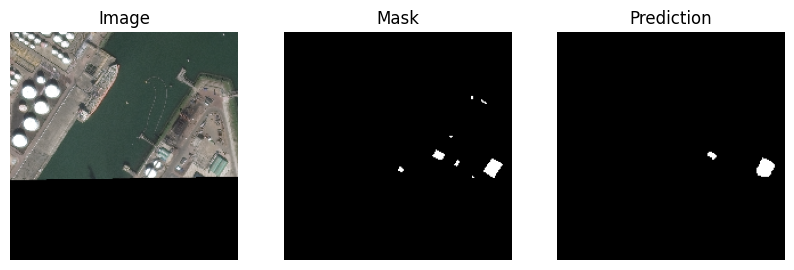

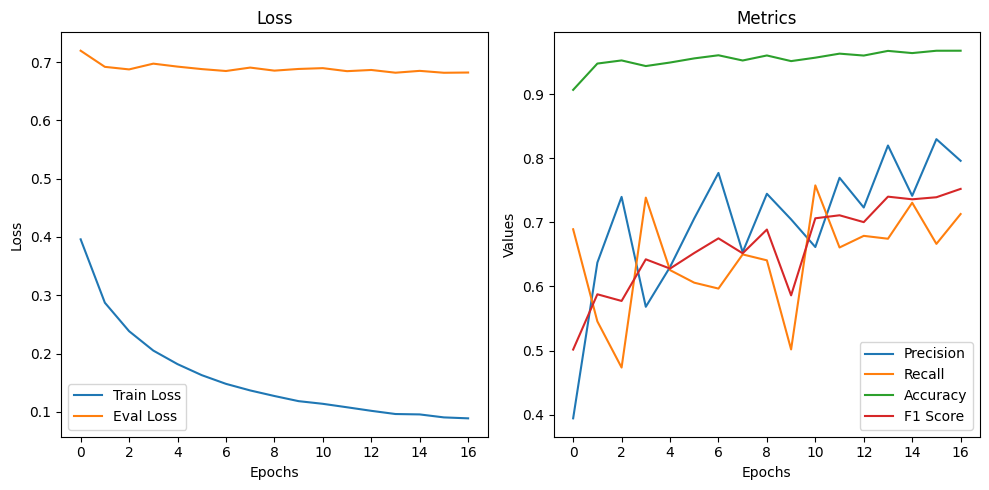

In [10]:
import matplotlib.pyplot as plt

# Get the history
history, _ = utils.load_checkpoint(CHECKPOINT_PATH + "checkpoint.pth", model)
image, mask, pred = utils.get_random_image(eval_loader, model, device)
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + "baseline.png")

train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + "metrics_baseline.png")
plt.show()

# Sources

https://www.nature.com/articles/s41598-024-56706-x 
https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f